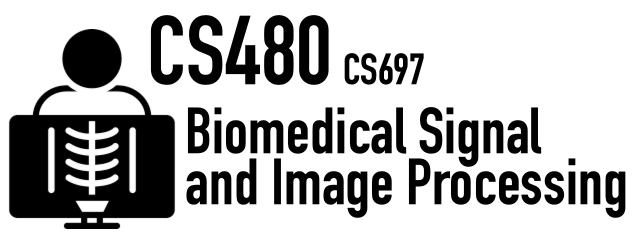
#Assignment 6

In [2]:
# In this assignment, we will train a U-Net classifer to detect mitochondria
# in electron microscopy images!

In [2]:
### IMPORTANT ###
#
# Activate GPU support: Runtime -> Change Runtime Type
# Hardware Accelerator: GPU
#
### IMPORTANT ###

In [1]:
# load numpy and matplotlib
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# load the unet tensorflow code
!pip install git+https://github.com/jakeret/unet.git

  Cloning https://github.com/jakeret/unet.git to /tmp/pip-req-build-_p56s2t4
  Running command git clone -q https://github.com/jakeret/unet.git /tmp/pip-req-build-_p56s2t4
  Created wheel for unet: filename=unet-0.0.post0.dev81+gf557a51-py2.py3-none-any.whl size=25658 sha256=ced2089ef1bb192aa8bf81699b03d33a80205a0f7d9b134d906136b15b15ee4c
  Stored in directory: /tmp/pip-ephem-wheel-cache-9fpr2in9/wheels/f5/38/c8/8f0a157cfd7616cc1a24811a52b9a669c0ee8fccc9f99d3cbc
Successfully built unet


In [3]:
# .. and use it!
# Note: There are a ton of U-Net implementations but this one is easier to use!
import unet

**Task 1**: Study the unet circle example and learn about mitochondria! [15 Points]

In [ ]:
# The unet package allows to train a U-Net classifier with little code.
# As discussed in class, the U-Net can be used to label/segment/annotate images.

In [ ]:
# TODO: Please study the Circles example 
# https://github.com/jakeret/unet/blob/master/notebooks/circles.ipynb

In [ ]:
# TODO: ... and look how the (artificial) dataset is generated
# https://github.com/jakeret/unet/blob/master/src/unet/datasets/circles.py

In [ ]:
# 1) Question
# TODO: Please describe what the U-Net is trained to do.

The U-net in circles.py and circles.ipynb can detect circles in a noisy image. The ipynb contains the code for the u-net and it's set up while the circles.py creates noisy images and its masks

In [ ]:
# 2) Question
# TODO: In circles.py, what does the following mean:
#     channels = 1
#     classes = 2

Channels and classes seem not to be used in the circles.py file but they are called in the ipython notebook to build the u-net model. 
I guess by channels usually RGB channels are meant, so here there is only one channel which might be gray. We have to predict two classes: black or white. In the circles.py the masks are created with either making a pixel inside a circle white or making a background pixel black. The predicted mask will also only consist of two classes: black and white.

In [ ]:
# 3) Question
# TODO: What are mitochondria and what is their appearance in
# electron microscopy data?
# Hint: You can validate your answer in Task 4!

Mitochondria are a parts (or *organelles*) of cells that produce energy in form of ATP. They have two outer membranes, and vary in shape and number depending on the cell type (red blood cells for example have no mitochondria). 
In the electron microscopy they appear darker compared the background and other parts of the cells. We can sometimes see the structure of the two outer mitochondria membranes with the intramembrane space being darker.


**Task 2**: Setup a datagenerator for mitochondria images! [45 Points]

In [ ]:
# TODO: 
# Download https://cs480.org/data/mito.npz to your computer.
# Then, please upload mito.npz using the file panel on the left.

In [ ]:
# The code below is similar to the circles.py file from Task 1.
# We follow Tensorflow conventions to design a tf.data.Dataset for training
# the U-Net.
#
# TODO: Please add four different data augmentation methods in the code block
# below. (image normalization to 0..1, horizontal data flip, vertical data flip,
# rotation by 90 degrees)
#
# Hint: https://github.com/jakeret/unet/blob/master/src/unet/datasets/oxford_iiit_pet.py#L25

In [7]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_datasets.core import DatasetInfo
from typing import Tuple, List

IMAGE_SIZE = (256, 256)
channels = 1
classes = 2

def load_data(count:int, splits:Tuple[float]=(0.7, 0.2, 0.1), **kwargs) -> List[tf.data.Dataset]:
    return [tf.data.Dataset.from_tensor_slices(_build_samples(int(split * count), **kwargs))
            for split in splits]


def _build_samples(sample_count:int, **kwargs) -> Tuple[np.array, np.array]:

    # here we load the mitochondria data
    loaded = np.load('mito.npz')
    loadedimages = loaded['arr_0'][0].copy()
    loadedmasks = loaded['arr_0'][1].copy()

    # now let's go to numpyland
    images = np.empty((sample_count, IMAGE_SIZE[0], IMAGE_SIZE[1], 1))
    labels = np.empty((sample_count, IMAGE_SIZE[0], IMAGE_SIZE[1], 2))
    for i in range(sample_count):
        image, mask = loadedimages[i], loadedmasks[i]

        image = image.reshape((IMAGE_SIZE[0], IMAGE_SIZE[1], 1)).astype(np.float)
        mask = mask.reshape((IMAGE_SIZE[0], IMAGE_SIZE[1], 1))

        #
        # TODO: Normalize the image to 0..1
        
        # similar to circles.py: at first subtracting the minimum value to make the minimum value 0:
        image -= np.amin(image)
        # then dividing by max which will set the max value to 1:
        image /= np.amax(image)

        #
        # TODO: Use Tensorflow to flip the image horizontally
        #
        if tf.random.uniform(()) > 0.5:
            image = tf.image.flip_left_right(image)
            mask = tf.image.flip_left_right(mask)
        #
        # TODO: Use Tensorflow to flip the image vertically
        #
        if tf.random.uniform(()) > 0.5:
            image = tf.image.flip_up_down(image)
            mask = tf.image.flip_up_down(mask)

        #
        # TODO: Use Tensorflow to rotate the image 90 degrees
        #
        if tf.random.uniform(()) > 0.5:
            image = tf.image.rot90(image)
            mask = tf.image.rot90(mask)

        # augmentation done, let's store the image
        images[i] = image

        # here we split the mask to background and foreground
        fg = np.zeros((IMAGE_SIZE[0], IMAGE_SIZE[1], 1), dtype=np.bool)
        fg[mask == 255] = 1
        bg = np.zeros((IMAGE_SIZE[0], IMAGE_SIZE[1], 1), dtype=np.bool)
        bg[mask == 0] = 1
        
        labels[i, :, :, 0] = bg[:,:,0]
        labels[i, :, :, 1] = fg[:,:,0]

    return images, labels

**Task 3**: Let's train the U-Net! [25 Points]

In [8]:
#
# We can now create our training, validation, and testing data by calling
# our methods from Task 2.
#
train, val, test = load_data( 660, splits=(0.7, 0.2, 0.1) )

In [ ]:
# 1) Question
# TODO: We have in total 660 images + 660 masks. Based on the code above,
# how many images are used for training alone?

660 * 0.7 = 462 images

70% of the 660 images are used for training the U-net, so 462 training images.


In [9]:
#
# Let's setup the U-Net!
#
LEARNING_RATE = 1e-3

unet_model = unet.build_model(channels=channels,
                              num_classes=classes,
                              layer_depth=5,
                              filters_root=64,
                              padding="same")

unet.finalize_model(unet_model, learning_rate=LEARNING_RATE)

In [10]:
#
# And, let's setup the trainer...
#
trainer = unet.Trainer(checkpoint_callback=False,
                       learning_rate_scheduler=unet.SchedulerType.WARMUP_LINEAR_DECAY,
                       warmup_proportion=0.1,
                       learning_rate=LEARNING_RATE)

In [11]:
#
# ...and train the U-Net for 50 epochs with a batch_size of 10!
#
# TODO: Please complete the code below.
# Hint: Don't forget to use training and validation data.
# Hint 2: This will take roughly 30 minutes!
#
trainer.fit(unet_model,
            train,
            val,
            epochs=50,
            batch_size=10)

Epoch 1/50
47/47 [==============================] - 63s 1s/step - loss: 0.6763 - categorical_crossentropy: 0.6763 - categorical_accuracy: 0.5211 - mean_iou: 0.2866 - dice_coefficient: 0.5225 - auc: 0.4735 - val_loss: 0.4969 - val_categorical_crossentropy: 0.4969 - val_categorical_accuracy: 0.9434 - val_mean_iou: 0.3291 - val_dice_coefficient: 0.6111 - val_auc: 0.9836
Epoch 2/50
47/47 [==============================] - 41s 867ms/step - loss: 0.3164 - categorical_crossentropy: 0.3164 - categorical_accuracy: 0.9205 - mean_iou: 0.4382 - dice_coefficient: 0.8246 - auc: 0.9394 - val_loss: 0.3972 - val_categorical_crossentropy: 0.3972 - val_categorical_accuracy: 0.9434 - val_mean_iou: 0.3655 - val_dice_coefficient: 0.6799 - val_auc: 0.9843
Epoch 3/50
47/47 [==============================] - 41s 866ms/step - loss: 0.3021 - categorical_crossentropy: 0.3021 - categorical_accuracy: 0.9210 - mean_iou: 0.4399 - dice_coefficient: 0.8272 - auc: 0.9395 - val_loss: 0.2211 - val_categorical_crossentropy

**Task 4**: Let's predict mitochondria in the testing data! [15 Points]

In [ ]:
# 
# After training, let's try the U-Net on our testing data.
#
# The code below displays the first 10 input images, the original masks by experts, 
# and the predicted masks from the U-Net.

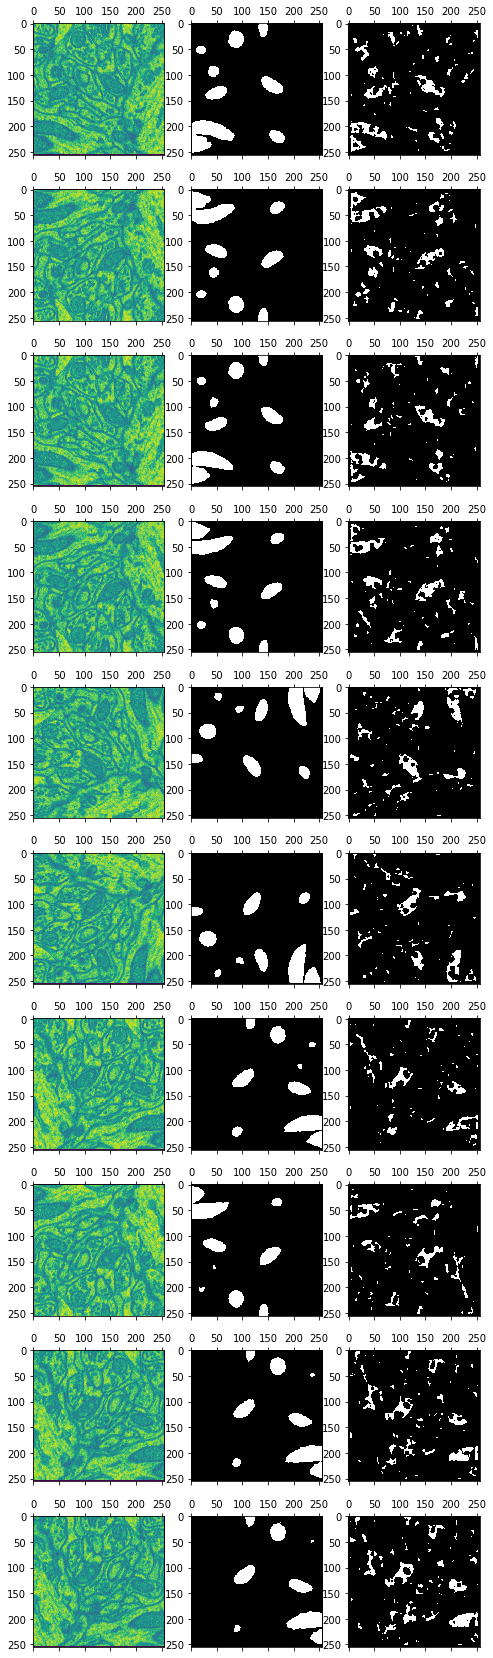

In [15]:
rows = 10
fig, axs = plt.subplots(rows, 3, figsize=(8, 30))
for ax, (image, label) in zip(axs, test.take(rows).batch(1)):
  
  prediction = unet_model.predict(image)
  ax[0].matshow(image[0, :, :, 0])
  ax[1].matshow(label[0, :, :, 1], cmap="gray")
  ax[2].matshow(prediction[0].argmax(axis=-1), cmap="gray")

In [ ]:
# 1) Question
# TODO: Why do we use the prediction[0].argmax(axis=-1) command
# to display the prediction?

Calling the argmax(axis=-1) on the output prediction array returns the index of the max value and finds the class with highest predicted likelihood. So it can tell us to which class the prediction might belong (1 or 0, black or white in this case).

In [ ]:
# 2) Question
# TODO: Is the quality of the segmentation good and how could we improve it?
# Hint: Think along the lines of some traditional image processing rather than
# increasing the training data size.
#
# TODO: YOUR ANSWER

For me it did not turn out that good - we call still see that the network highlighted some areas that were no mitochondria! 
But some traditional image processing methods improving the network output could be thresholding/filtering/setting higher contrasts or sharpening the image to make the membranes of the cells more visible. Maybe also using Gaussian bandpass filters could be tested, especially to blurr the intramembrane spaces.

**Bonus**: Compare against the state-of-the-art literature! [33 Points]

In [ ]:
#
# The following paper also uses a 2D U-Net to detect mitochondria:
# 
# https://danielhaehn.com/papers/?casser2020fast
#

In [ ]:
# 1) Question
#
# TODO: How many learnable parameters does your trained unet_model have?
# Hint: You can use TF's Model Summary function to answer this.
#

In [16]:
unet_model.summary()

Model: "unet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv_block (ConvBlock)          (None, None, None, 6 37568       inputs[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, None, None, 6 0           conv_block[0][0]                 
__________________________________________________________________________________________________
conv_block_1 (ConvBlock)        (None, None, None, 1 221440      max_pooling2d[0][0]              
_______________________________________________________________________________________________

There is a total of 31,030,658 parameters for our model.

In [ ]:
# 2) Question
#
# TODO: How many parameters do Casser et al. use?
#

The authors used 1,178,480 parameters for encoding and 780,053 for encoding. So way less than we used in our model!

In [ ]:
# 3) Question
#
# TODO: How did Casser et al. reduce the parameters?
#

They created a light-weight form of a 2D U-Net by using less convolutional filters and replacing some layers with bilinear upsampling layers that do not need any parameters.





In [ ]:
# 4) Question
#
# TODO: Why did Casser et al. reduce the parameters?
#

The authors aim for a fast network that can run in real-time with high accuracy, also due to large datasets of mitochondria that have to be processed. With less parameters the network is way faster.

In [ ]:
#
# You made it!!
#
#                 _ ___                /^^\ /^\  /^^\_
#     _          _@)@) \            ,,/ '` ~ `'~~ ', `\.
#   _/o\_ _ _ _/~`.`...'~\        ./~~..,'`','',.,' '  ~:
#  / `,'.~,~.~  .   , . , ~|,   ,/ .,' , ,. .. ,,.   `,  ~\_
# ( ' _' _ '_` _  '  .    , `\_/ .' ..' '  `  `   `..  `,   \_
#  ~V~ V~ V~ V~ ~\ `   ' .  '    , ' .,.,''`.,.''`.,.``. ',   \_
#   _/\ /\ /\ /\_/, . ' ,   `_/~\_ .' .,. ,, , _/~\_ `. `. '.,  \_
#  < ~ ~ '~`'~'`, .,  .   `_: ::: \_ '      `_/ ::: \_ `.,' . ',  \_
#   \ ' `_  '`_    _    ',/ _::_::_ \ _    _/ _::_::_ \   `.,'.,`., \-,-,-,_,_,
#    `'~~ `'~~ `'~~ `'~~  \(_)(_)(_)/  `~~' \(_)(_)(_)/ ~'`\_.._,._,'_;_;_;_;_;
#